In [2]:
# General utilities
import os
import glob
import gzip
import logging
import warnings

# Numerical and data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# Bioinformatics and scientific computing
import scanpy as sc
import anndata
import scipy
import h5py
import torch
import mira
import pygenometracks

# Configure warnings and MIRA output
warnings.simplefilter("ignore")
mira.utils.pretty_sderr()

In [3]:
%config Completer.use_jedi = False

In [4]:
%matplotlib inline

In [5]:
torch.cuda.is_available()

True

In [6]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)

NVIDIA A100-PCIE-40GB


In [3]:
adata = sc.read_h5ad('/ix/djishnu/Common_Folder/Jingyu_Data/ISD/adata_aggregated_ATAC.ISD.h5ad')
adata

AnnData object with n_obs × n_vars = 32418 × 191255
    obs: 'cell_type_major', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'cell_index', 'softmax_denom'
    var: 'gene_ids', 'feature_types', 'genome', 'chr', 'start', 'end'
    uns: 'TSS_metadata', 'cell_type_major_colors', 'chip', 'distance_to_TSS_genes', 'motifs', 'neighbors', 'topic_dendogram', 'umap'
    obsm: 'X_joint_umap_features', 'X_topic_compositions', 'X_umap', 'X_umap_features'
    varm: 'chip_hits', 'distance_to_TSS', 'motifs_hits', 'topic_feature_activations', 'topic_feature_compositions'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
atac_model = mira.topics.load_model('/ix/djishnu/peasena/primary_multiome/donor1_upmc/mira_models/topic_models/multiome_1st_donor_UPMC_aggr_atac_topic_model.2.pth')

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [9]:
# this part will take some time. (~2-4hrs and >=32gb)
mira.tl.get_ChIP_hits_in_peaks(adata, 
    chrom = "chr", start = "start", end = "end",
    species = "hg38")

In [10]:
motif_scores_chip = atac_model.get_motif_scores(adata,factor_type='chip')

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/127 [00:00<?, ?it/s]

In [11]:
motif_scores_chip.var

,id,name,parsed_name
0,1006,EOMES,EOMES
1,1010,FOXH1,FOXH1
2,1011,FOXH1,FOXH1
3,1012,FOXP1,FOXP1
4,1013,FOXP1,FOXP1
...,...,...,...
6907,9508,TFAP2C,TFAP2C
6908,9509,TFAP2C,TFAP2C
6909,9510,TFAP2C,TFAP2C
6910,955,NANOG,NANOG


In [12]:
motif_scores_chip.write('/ix/djishnu/peasena/primary_multiome/donor1_upmc/h5_files/atac_chip_scores.h5ad')

... storing 'name' as categorical
... storing 'parsed_name' as categorical


In [15]:
# Rename strings in 'parsed_name' column by concatenating 'name' and 'id' columns
motif_scores_chip.var['parsed_name'] = motif_scores_chip.var['name'].astype(str) + '_' + motif_scores_chip.var['id'].astype(str)

In [16]:
motif_scores_chip.var

,id,name,parsed_name
0,1006,EOMES,EOMES_1006
1,1010,FOXH1,FOXH1_1010
2,1011,FOXH1,FOXH1_1011
3,1012,FOXP1,FOXP1_1012
4,1013,FOXP1,FOXP1_1013
...,...,...,...
6907,9508,TFAP2C,TFAP2C_9508
6908,9509,TFAP2C,TFAP2C_9509
6909,9510,TFAP2C,TFAP2C_9510
6910,955,NANOG,NANOG_955


In [17]:
motif_scores_chip.var = motif_scores_chip.var.reset_index().set_index('parsed_name')
motif_scores_chip.var_names_make_unique()
motif_scores_chip.obsm['X_umap'] = adata.obsm['X_umap']

In [22]:
motif_scores_chip.write('/ix/djishnu/peasena/primary_multiome/donor1_upmc/h5_files/atac_chip_scores.h5ad')

# phase II starting point

In [3]:
motif_scores_chip = sc.read_h5ad('/ix/djishnu/peasena/primary_multiome/donor1_upmc/h5_files/atac_chip_scores.h5ad')
motif_scores_chip

AnnData object with n_obs × n_vars = 32418 × 6912
    obs: 'cell_type_major', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'cell_index', 'softmax_denom'
    var: 'index', 'id', 'name'
    obsm: 'X_umap'
    layers: 'raw_logp_binding'

In [4]:
motif_scores_chip.var

,index,id,name
parsed_name,,,
EOMES_1006,0,1006,EOMES
FOXH1_1010,1,1010,FOXH1
FOXH1_1011,2,1011,FOXH1
FOXP1_1012,3,1012,FOXP1
FOXP1_1013,4,1013,FOXP1
...,...,...,...
TFAP2C_9508,6907,9508,TFAP2C
TFAP2C_9509,6908,9509,TFAP2C
TFAP2C_9510,6909,9510,TFAP2C


In [6]:
adata = sc.read_h5ad('/ix/djishnu/peasena/primary_multiome/donor1_upmc/h5_files/donor1_multiome_gex_final.h5ad')
adata

AnnData object with n_obs × n_vars = 31314 × 23090
    obs: 'sample', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'score_G1S', 'score_G2M', 'score_PB', 'dpt_pseudotime', 'score_total_GC', 'predicted_labels', 'prob_ActB', 'prob_GCBC', 'prob_MBC', 'prob_NBC', 'prob_PC', 'score_myc_up', 'score_LZ_GC'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_major_colors', 'diffmap_evals', 'draw_graph', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'topic_dendogram', 'umap'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_joint_umap

In [7]:
# Remove specified slots from adata.obs
slots_to_remove = [
    'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'cell_index', 'softmax_denom'
]

# Create a new AnnData object without the specified columns
motif_scores_chip.obs = motif_scores_chip.obs.drop(columns=slots_to_remove, errors='ignore')

motif_scores_chip

AnnData object with n_obs × n_vars = 32418 × 6912
    obs: 'cell_type_major'
    var: 'index', 'id', 'name'
    obsm: 'X_umap'
    layers: 'raw_logp_binding'

In [8]:
# Subset motif_scores_chip to retain only the cells present in adata
common_cells = motif_scores_chip.obs.index.intersection(adata.obs.index)
motif_scores_chip = motif_scores_chip[common_cells, :].copy()  # Create a new subsetted AnnData object
motif_scores_chip

AnnData object with n_obs × n_vars = 31314 × 6912
    obs: 'cell_type_major'
    var: 'index', 'id', 'name'
    obsm: 'X_umap'
    layers: 'raw_logp_binding'

In [13]:
motif_scores_chip.obs['sample'] = adata.obs['sample'].copy()
motif_scores_chip.obs['predicted_labels'] = adata.obs['predicted_labels'].copy()
motif_scores_chip.obs['leiden'] = adata.obs['leiden'].copy()
motif_scores_chip.uns['leiden_colors'] = adata.uns['leiden_colors'].copy()

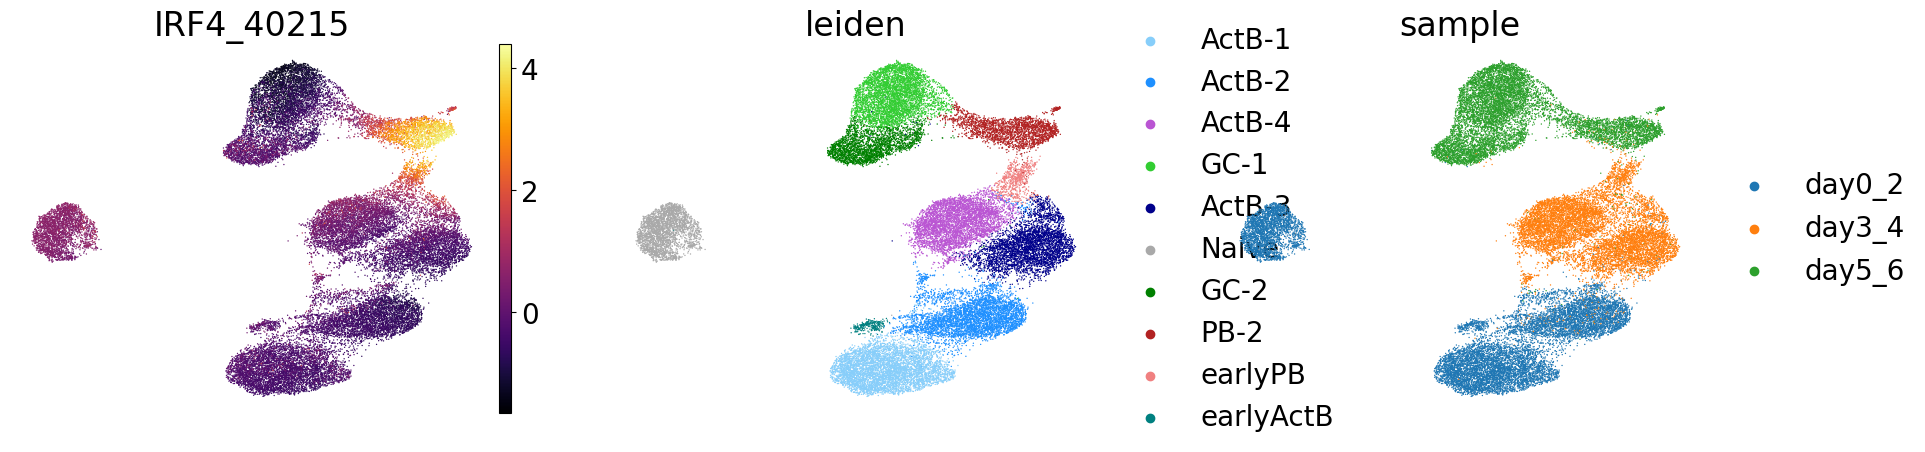

In [14]:
sc.pl.umap(motif_scores_chip, color = ['IRF4_40215', 'leiden', 'sample'],
           frameon=False, color_map='inferno', ncols=4)

In [15]:
motif_scores_chip

AnnData object with n_obs × n_vars = 31314 × 6912
    obs: 'cell_type_major', 'sample', 'leiden', 'predicted_labels'
    var: 'index', 'id', 'name'
    uns: 'predicted_labels', 'leiden_colors', 'sample_colors'
    obsm: 'X_umap'
    layers: 'raw_logp_binding'

In [16]:
motif_scores_chip.uns.pop('predicted_labels', None)  # Removes key safely if it exists

AAACAGCCAAAGCTAA-1    Activated NBC
AAACAGCCAAGCCACT-3             GCBC
AAACAGCCAAGGTGCA-1             GCBC
AAACAGCCAAGTTATC-1    Activated NBC
AAACAGCCAATAGCCC-1    Activated NBC
                          ...      
TTTGTTGGTTTACGTC-1    Activated NBC
TTTGTTGGTTTAGTCC-1    Activated NBC
TTTGTTGGTTTATGGG-2             GCBC
TTTGTTGGTTTCCTCC-3             GCBC
TTTGTTGGTTTGAGGC-2             GCBC
Name: predicted_labels, Length: 31314, dtype: category
Categories (5, object): ['Activated NBC', 'GCBC', 'MBC', 'NBC', 'PC']

In [17]:
motif_scores_chip

AnnData object with n_obs × n_vars = 31314 × 6912
    obs: 'cell_type_major', 'sample', 'leiden', 'predicted_labels'
    var: 'index', 'id', 'name'
    uns: 'leiden_colors', 'sample_colors'
    obsm: 'X_umap'
    layers: 'raw_logp_binding'

In [18]:
motif_scores_chip.var = motif_scores_chip.var.rename(columns={'id': 'CistromeDB_ID', 'name': 'TF'})
motif_scores_chip.var

,index,CistromeDB_ID,TF
parsed_name,,,
EOMES_1006,0,1006,EOMES
FOXH1_1010,1,1010,FOXH1
FOXH1_1011,2,1011,FOXH1
FOXP1_1012,3,1012,FOXP1
FOXP1_1013,4,1013,FOXP1
...,...,...,...
TFAP2C_9508,6907,9508,TFAP2C
TFAP2C_9509,6908,9509,TFAP2C
TFAP2C_9510,6909,9510,TFAP2C


In [19]:
motif_scores_chip.write('/ix/djishnu/peasena/primary_multiome/donor1_upmc/h5_files/donor1_multiome_atac_chip_scores.h5ad')

In [26]:
factors = mira.utils.fetch_factor_meta(adata, factor_type = 'chip')
factors[factors.name == 'IRF4']

,id,name,parsed_name
992,40215,IRF4,IRF4
2115,46128,IRF4,IRF4
2545,48623,IRF4,IRF4
2549,48628,IRF4,IRF4
2552,48632,IRF4,IRF4
2555,48636,IRF4,IRF4
2558,48640,IRF4,IRF4


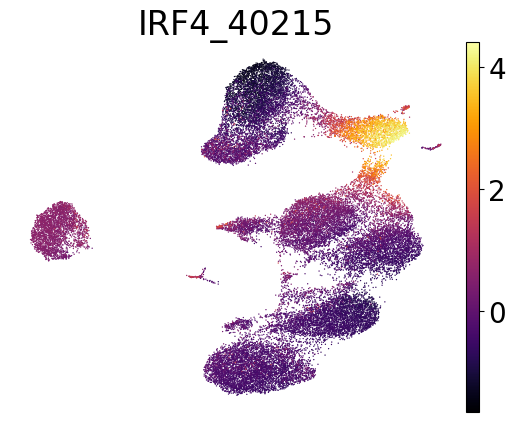

In [5]:
sc.pl.umap(motif_scores_chip, color = ['IRF4_40215'],
           frameon=False, color_map='inferno', ncols=4)

# visualize RP models with chip hits

In [5]:
from IPython.display import Image


In [6]:
#!mkdir -p /ix/djishnu/peasena/primary_multiome/donor1_upmc/data/trackdata

In [7]:
track_data_path = '/ix/djishnu/peasena/primary_multiome/donor1_upmc/data/trackdata/'

In [8]:
#factors = mira.utils.fetch_factor_meta(adata, factor_type = 'chip')

In [9]:
#filtered_factors = factors[factors['name'].isin(['IRF4', 'PAX5', 'BCL6', 'EBF1', 'RELB', 'BACH2'])]

In [10]:
# Ensure 'chip' exists and contains 'id' and 'parsed_name'
if 'chip' in adata.uns and 'id' in adata.uns['chip'] and 'parsed_name' in adata.uns['chip']:
    # Convert both columns to strings and concatenate
    adata.uns['chip']['id'] = [
        f"{parsed}_{chip_id}" for parsed, chip_id in zip(adata.uns['chip']['parsed_name'], adata.uns['chip']['id'])
    ]
else:
    print("Error: 'chip', 'id', or 'parsed_name' keys are missing in adata.uns.")

# aicda locus

In [24]:
# Define chip IDs
chip_ids = ['BCL6_35517', 'IRF4_48623', 'STAT1_45643', 'EBF1_59344']

# Loop through each chip ID and fetch binding sites
for chip_id in chip_ids:
    chip_subset = mira.utils.fetch_binding_sites(adata, id=chip_id, factor_type='chip')

    # Sort by chromosome and start site
    sorted_chip_subset = chip_subset[['chr', 'start', 'end']].sort_values(['chr', 'start'])

    # Define output file path
    output_file = os.path.join(track_data_path, f"{chip_id}_hits.bed")

    # Save as BED file
    sorted_chip_subset.to_csv(output_file, index=None, header=None, sep='\t')

print("✅ BED files successfully created for all chip IDs.")

✅ BED files successfully created for all chip IDs.


In [25]:
tss_gene = "AICDA"

In [26]:
config_file = """

[x-axis]

[genes]
file = /ix/djishnu/peasena/primary_multiome/donor1_upmc/mira-datasets/hg38_tss_data_filtered.bed12
title = Genes
height = 3

[rp model]
file = /ix/djishnu/peasena/primary_multiome/donor1_upmc/mira_models/rp_model_bedgraphs/AICDA_rpmodel.bedgraph
height = 3
color = #e6e6e6
title = AICDA RP Model
max_value = 1.1
min_value = 0
file_type = bedgraph
alpha = 0.2

[rp model2]
file = /ix/djishnu/peasena/primary_multiome/donor1_upmc/mira_models/rp_model_bedgraphs/AICDA_rpmodel.bedgraph
type = line:0.5
color = black
file_type = bedgraph
max_value = 1.1
min_value = 0
overlay previous = yes

[bigwig file test]
file = /ix/djishnu/Jered/chrombpnet/Primary_Human_GRN/cluster_6_tags/cluster_6_merge.bw
# height of the track in cm (optional value)
height = 3
title = GC-2 ATAC
color = green
min_value = 0
max_value = 2

[spacer]

# ['BCL6_35517', 'IRF4_48623', 'STAT1_45643', 'EBF1_59344']

[PAX5 hits]
file = /ix/djishnu/peasena/primary_multiome/donor1_upmc/data/trackdata/BCL6_35517_hits.bed
height = 1.5
style = UCSC
gene_rows = 1
color = black
title = BCL6
labels = off

[PAX5 hits]
file = /ix/djishnu/peasena/primary_multiome/donor1_upmc/data/trackdata/IRF4_48623_hits.bed
height = 1.5
style = UCSC
gene_rows = 1
color = black
title = IRF4
labels = off


[PAX5 hits]
file = /ix/djishnu/peasena/primary_multiome/donor1_upmc/data/trackdata/STAT1_45643_hits.bed
height = 1.5
style = UCSC
gene_rows = 1
color = black
title = STAT1
labels = off


[PAX5 hits]
file = /ix/djishnu/peasena/primary_multiome/donor1_upmc/data/trackdata/EBF1_59344_hits.bed
height = 1.5
style = UCSC
gene_rows = 1
color = black
title = EBF1
labels = off


"""

with open('/ix/djishnu/peasena/primary_multiome/donor1_upmc/data/trackdata/config.ini', 'w') as f:
    print(config_file, file = f)

In [35]:
import subprocess

# Fetch TSS data and adjust window size
tss_data = mira.utils.fetch_TSS_data(adata)[tss_gene]
tss_gene_chr = tss_data['gene_chrom'] 
tss_gene_start = tss_data['gene_start'] - 50000
tss_gene_end = tss_data['gene_end'] + 350000

# Define the command with correctly formatted variables
cmd = [
    "pyGenomeTracks",
    "--tracks", "/ix/djishnu/peasena/primary_multiome/donor1_upmc/data/trackdata/config.ini",
    "--region", f"{tss_gene_chr}:{tss_gene_start}-{tss_gene_end}",
    "-out", f"{track_data_path}/{tss_gene}_chip_plot.pdf",
    "--dpi", "300",
    "--width", "20",
    "--fontSize", "9"
]

# Run the command
subprocess.run(cmd)






INFO:pygenometracks.tracksClass:initialize 1. [x-axis]
INFO:pygenometracks.tracksClass:initialize 2. [genes]
100%|██████████| 29/29 [00:00<00:00, 26662.61it/s]
INFO:pygenometracks.tracksClass:initialize 3. [rp model]
100%|██████████| 8156/8156 [00:00<00:00, 35142.66it/s]
INFO:pygenometracks.tracksClass:initialize 4. [rp model2]
100%|██████████| 8156/8156 [00:00<00:00, 63683.98it/s]
INFO:pygenometracks.tracksClass:initialize 5. [bigwig file test]
INFO:pygenometracks.tracksClass:initialize 6. [spacer]
INFO:pygenometracks.tracksClass:initialize 7. [PAX5 hits]
100%|██████████| 12/12 [00:00<00:00, 33554.43it/s]
INFO:pygenometracks.tracksClass:initialize 8. [PAX5 hits]
100%|██████████| 11/11 [00:00<00:00, 21783.45it/s]
INFO:pygenometracks.tracksClass:initialize 9. [PAX5 hits]
100%|██████████| 4/4 [00:00<00:00, 15782.89it/s]
INFO:pygenometracks.tracksClass:initialize 10. [PAX5 hits]
100%|██████████| 6/6 [00:00<00:00, 19093.95it/s]
INFO:pygenometracks.tracksClass:time initializing track(s

CompletedProcess(args=['pyGenomeTracks', '--tracks', '/ix/djishnu/peasena/primary_multiome/donor1_upmc/data/trackdata/config.ini', '--region', 'chr12:8552169-8962859', '-out', '/ix/djishnu/peasena/primary_multiome/donor1_upmc/data/trackdata//AICDA_chip_plot.pdf', '--dpi', '300', '--width', '20', '--fontSize', '9'], returncode=0)

# prdm1 locus

In [36]:
# Define chip IDs
chip_ids = ['TCF12_46120', 'IRF4_48632', 'PAX5_46138', 'BACH2_39577']

# Loop through each chip ID and fetch binding sites
for chip_id in chip_ids:
    chip_subset = mira.utils.fetch_binding_sites(adata, id=chip_id, factor_type='chip')

    # Sort by chromosome and start site
    sorted_chip_subset = chip_subset[['chr', 'start', 'end']].sort_values(['chr', 'start'])

    # Define output file path
    output_file = os.path.join(track_data_path, f"{chip_id}_hits.bed")

    # Save as BED file
    sorted_chip_subset.to_csv(output_file, index=None, header=None, sep='\t')

print("✅ BED files successfully created for all chip IDs.")

✅ BED files successfully created for all chip IDs.


In [37]:
tss_gene = "PRDM1"

In [38]:
config_file = """

[x-axis]

[genes]
file = /ix/djishnu/peasena/primary_multiome/donor1_upmc/mira-datasets/hg38_tss_data_filtered.bed12
title = Genes
height = 3

[rp model]
file = /ix/djishnu/peasena/primary_multiome/donor1_upmc/mira_models/rp_model_bedgraphs/PRDM1_rpmodel.bedgraph
height = 3
color = #e6e6e6
title = PRDM1 RP Model
max_value = 1.1
min_value = 0
file_type = bedgraph
alpha = 0.2

[rp model2]
file = /ix/djishnu/peasena/primary_multiome/donor1_upmc/mira_models/rp_model_bedgraphs/PRDM1_rpmodel.bedgraph
type = line:0.5
color = black
file_type = bedgraph
max_value = 1.1
min_value = 0
overlay previous = yes

[bigwig file test]
file = /ix/djishnu/Jered/chrombpnet/Primary_Human_GRN/cluster_7_tags/cluster_7_merge.bw
# height of the track in cm (optional value)
height = 3
title = PB ATAC
color = #d51313
min_value = 0
max_value = 1.5

[spacer]

#chip_ids = ['TCF12_46120', 'IRF4_48632', 'PAX5_46138', 'BACH2_39577']

[PAX5 hits]
file = /ix/djishnu/peasena/primary_multiome/donor1_upmc/data/trackdata/IRF4_48632_hits.bed
height = 1.5
style = UCSC
gene_rows = 1
color = black
title = IRF4
labels = off

[PAX5 hits]
file = /ix/djishnu/peasena/primary_multiome/donor1_upmc/data/trackdata/TCF12_46120_hits.bed
height = 1.5
style = UCSC
gene_rows = 1
color = black
title = TCF12
labels = off


[PAX5 hits]
file = /ix/djishnu/peasena/primary_multiome/donor1_upmc/data/trackdata/BACH2_39577_hits.bed
height = 1.5
style = UCSC
gene_rows = 1
color = black
title = BACH2
labels = off


[PAX5 hits]
file = /ix/djishnu/peasena/primary_multiome/donor1_upmc/data/trackdata/PAX5_46138_hits.bed
height = 1.5
style = UCSC
gene_rows = 1
color = black
title = PAX5
labels = off

"""

with open('/ix/djishnu/peasena/primary_multiome/donor1_upmc/data/trackdata/config.ini', 'w') as f:
    print(config_file, file = f)

In [39]:
import subprocess

# Fetch TSS data and adjust window size
tss_data = mira.utils.fetch_TSS_data(adata)[tss_gene]
tss_gene_chr = tss_data['gene_chrom'] 
tss_gene_start = tss_data['gene_start'] - 350000
tss_gene_end = tss_data['gene_end'] + 50000

# Define the command with correctly formatted variables
cmd = [
    "pyGenomeTracks",
    "--tracks", "/ix/djishnu/peasena/primary_multiome/donor1_upmc/data/trackdata/config.ini",
    "--region", f"{tss_gene_chr}:{tss_gene_start}-{tss_gene_end}",
    "-out", f"{track_data_path}/{tss_gene}_chip_plot.pdf",
    "--dpi", "300",
    "--width", "20",
    "--fontSize", "9"
]

# Run the command
subprocess.run(cmd)






INFO:pygenometracks.tracksClass:initialize 1. [x-axis]
INFO:pygenometracks.tracksClass:initialize 2. [genes]
100%|██████████| 6/6 [00:00<00:00, 9915.61it/s]
INFO:pygenometracks.tracksClass:initialize 3. [rp model]
100%|██████████| 8414/8414 [00:00<00:00, 33656.10it/s]
INFO:pygenometracks.tracksClass:initialize 4. [rp model2]
100%|██████████| 8414/8414 [00:00<00:00, 62964.77it/s]
INFO:pygenometracks.tracksClass:initialize 5. [bigwig file test]
INFO:pygenometracks.tracksClass:initialize 6. [spacer]
INFO:pygenometracks.tracksClass:initialize 7. [PAX5 hits]
100%|██████████| 11/11 [00:00<00:00, 30155.13it/s]
INFO:pygenometracks.tracksClass:initialize 8. [PAX5 hits]
100%|██████████| 24/24 [00:00<00:00, 47957.74it/s]
INFO:pygenometracks.tracksClass:initialize 9. [PAX5 hits]
100%|██████████| 6/6 [00:00<00:00, 21059.27it/s]
INFO:pygenometracks.tracksClass:initialize 10. [PAX5 hits]
100%|██████████| 24/24 [00:00<00:00, 47957.74it/s]
INFO:pygenometracks.tracksClass:time initializing track(s)

CompletedProcess(args=['pyGenomeTracks', '--tracks', '/ix/djishnu/peasena/primary_multiome/donor1_upmc/data/trackdata/config.ini', '--region', 'chr6:105736335-106159938', '-out', '/ix/djishnu/peasena/primary_multiome/donor1_upmc/data/trackdata//PRDM1_chip_plot.pdf', '--dpi', '300', '--width', '20', '--fontSize', '9'], returncode=0)